In [1]:
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [5]:
import seaborn as sns

In [199]:
def features_choices_15(bench,drop_list,names,info,model):
    bench["age"] = bench["DataYear"]-bench["YearBuilt"]
    bench = bench.drop(columns=drop_list)
    bench = bench.rename(names,axis='columns')
    bench['lat']=bench['loc'].apply(lambda r:r.split('\'')[3]).astype('float')
    bench['lon']=bench['loc'].apply(lambda r:r.split('\'')[7]).astype('float')
    bench['adress']=bench['loc'].apply(lambda r:r.split('\'')[11].split(',')[0].split("\"")[3])
    bench = bench.drop(columns=['loc'])
    bench_info = bench[info]
    bench_model = bench[model]
    return bench_info, bench_model

In [200]:
def features_choices_16(bench,drop_list,names,info,model):
    bench["age"] = bench["DataYear"]-bench["YearBuilt"]
    bench = bench.drop(columns=drop_list)
    bench = bench.rename(names,axis='columns')
    bench_info = bench[info]
    bench_model = bench[model]
    return bench_info, bench_model

In [201]:
def features_choices(bench15_0, bench16_0, to_drop_15, to_drop_16, new_names_15, new_names_16, info_var, model_var):
    bench15_info, bench15_model = features_choices_15(bench15_0, to_drop_15, new_names_15, info_var, model_var)
    bench16_info, bench16_model = features_choices_16(bench16_0, to_drop_16, new_names_16, info_var, model_var)
    bench_info = pd.concat([bench15_info, bench16_info],axis=0)
    bench_info = bench_info.drop_duplicates(subset = ["id"]).reset_index(drop=True)
    bench_model = pd.concat([bench15_model, bench16_model],axis=0)
    bench_model = bench_model.drop_duplicates(subset = ["id"]).reset_index(drop=True)    
    return bench_info, bench_model

In [202]:
def boxplot(x):
    fig, ax = plt.subplots(figsize=(15,15))
    ax.boxplot(x, vert = False)
    plt.show()

In [220]:
def cleansing_and_imputation(bench_model):
    to_complete_cat = ['lput', 'sput', 'tput']
    for cat in to_complete_cat:
        bench_model[cat] = bench_model[cat].fillna('Aucun')
        bench_model[cat+'_gfa'] = bench_model[cat+'_gfa'].fillna(0)
    drop_idx = bench_model[(bench_model['energy_use'].isna())|(bench_model['ghg_emission'].isna())|(bench_model["nf"].isna())|(bench_model["total_gfa"]<0)].index
    bench_model = bench_model.drop(drop_idx)
    bench_model = bench_model.sort_values(by='id')
    return bench_model

In [93]:
bench15_0 = pd.read_csv(r"C:\Users\Nabil\Desktop\Openclassrooms\Projet4\2015-building-energy-benchmarking.csv")

In [94]:
bench16_0 = pd.read_csv(r"C:\Users\Nabil\Desktop\Openclassrooms\Projet4\2016-building-energy-benchmarking.csv")

In [95]:
to_drop_15 = ["DataYear","YearBuilt",'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood','PropertyGFAParking','ListOfAllPropertyUseTypes','YearsENERGYSTARCertified','SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)','GHGEmissionsIntensity(kgCO2e/ft2)','DefaultData', 'Comment', 'ComplianceStatus', 'Outlier', '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas','City Council Districts', 'SPD Beats']

In [96]:
new_names_15 = {'OSEBuildingID':'id', 'BuildingType':'type', 'PrimaryPropertyType':'primary_type', 'PropertyName':'name','Location':'loc', 'NumberofBuildings':'nb', 'NumberofFloors':'nf', 'PropertyGFATotal':'total_gfa', 'PropertyGFABuilding(s)':'building_gfa', 'LargestPropertyUseType':'lput', 'LargestPropertyUseTypeGFA':'lput_gfa', 'SecondLargestPropertyUseType':'sput', 'SecondLargestPropertyUseTypeGFA':'sput_gfa', 'ThirdLargestPropertyUseType':'tput', 'ThirdLargestPropertyUseTypeGFA':'tput_gfa', 'ENERGYSTARScore':'energy_score', 'SiteEnergyUse(kBtu)':'energy_use', 'GHGEmissions(MetricTonsCO2e)':'ghg_emission', 'Zip Codes':'zip'}

In [97]:
new_names_16 = {'OSEBuildingID':'id',  'BuildingType':'type', 'PrimaryPropertyType':'primary_type', 'PropertyName':'name', 'Address':'adress', 'ZipCode':'zip', 'Latitude':'lat', 'Longitude':'lon', 'NumberofBuildings':'nb', 'NumberofFloors':'nf', 'PropertyGFATotal':'total_gfa', 'PropertyGFABuilding(s)':'building_gfa', 'LargestPropertyUseType':'lput', 'LargestPropertyUseTypeGFA':'lput_gfa', 'SecondLargestPropertyUseType':'sput', 'SecondLargestPropertyUseTypeGFA':'sput_gfa', 'ThirdLargestPropertyUseType':'tput', 'ThirdLargestPropertyUseTypeGFA':'tput_gfa', 'ENERGYSTARScore':'energy_score', 'SiteEnergyUse(kBtu)':'energy_use', 'TotalGHGEmissions':'ghg_emission'}

In [98]:
to_drop_16 = ['DataYear','City', 'State','TaxParcelIdentificationNumber','CouncilDistrictCode', 'Neighborhood','YearBuilt','PropertyGFAParking','ListOfAllPropertyUseTypes','YearsENERGYSTARCertified','SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',  'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier', 'GHGEmissionsIntensity']

In [99]:
info_var = ['id', 'name', 'lat', 'lon', 'adress', 'energy_score', 'zip']

In [245]:
model_var = ['id', 'age', 'nb', 'nf', 'type', 'primary_type', 'building_gfa' ,'total_gfa', 'lput', 'lput_gfa', 'sput', 'sput_gfa', 'tput', 'tput_gfa', 'energy_score', 'energy_use', 'ghg_emission']

In [310]:
bench_info, bench_model = features_choices(bench15_0, bench16_0, to_drop_15, to_drop_16, new_names_15, new_names_16, info_var, model_var)

In [258]:
# bench_model[(bench_model.building_gfa<0)]

In [311]:
bench_model = bench_model.drop(bench_model[(bench_model.lput_gfa>bench_model.total_gfa)|(bench_model.sput_gfa>bench_model.total_gfa)|(bench_model.tput_gfa>bench_model.total_gfa)].index)

In [260]:
bench_model[(bench_model.total_gfa!=bench_model.lput_gfa)&(~bench_model.lput.isna())&(bench_model.tput.isna())&(bench_model.sput.isna())]

,id,age,nb,nf,type,primary_type,building_gfa,total_gfa,lput,lput_gfa,sput,sput_gfa,tput,tput_gfa,energy_score,energy_use,ghg_emission
5,9,16,1.0,2.0,Nonresidential COS,Other,60090,97288,Police Station,88830.0,NaN,NaN,NaN,NaN,NaN,1.205198e+07,304.62
6,10,89,1.0,11.0,NonResidential,Hotel,83008,83008,Hotel,81352.0,NaN,NaN,NaN,NaN,25.0,6.252842e+06,208.46
9,13,105,1.0,6.0,Multifamily MR (5-9),Mid-Rise Multifamily,62216,63712,Multifamily Housing,56132.0,NaN,NaN,NaN,NaN,2.0,4.587231e+06,170.00
20,26,99,1.0,10.0,NonResidential,Other,540360,540360,Courthouse,537150.0,NaN,NaN,NaN,NaN,67.0,5.333265e+07,1596.08
24,30,87,1.0,7.0,NonResidential,College/University,126593,126593,College/University,125000.0,NaN,NaN,NaN,NaN,NaN,9.791557e+06,308.60
27,33,14,1.0,10.0,NonResidential,Hotel,133585,171866,Hotel,128909.0,NaN,NaN,NaN,NaN,20.0,1.102694e+07,319.73
29,35,37,1.0,5.0,NonResidential,Hotel,52210,68410,Hotel,47994.0,NaN,NaN,NaN,NaN,60.0,4.341706e+06,125.57
34,41,60,1.0,2.0,NonResidential,Self-Storage Facility\n,126394,126394,Self-Storage Facility,26225.0,NaN,NaN,NaN,NaN,77.0,3.067210e+05,3.71
70,104,53,1.0,1.0,Nonresidential COS,Other,91213,91213,Other,65000.0,NaN,NaN,NaN,NaN,NaN,5.069854e+06,123.28
71,106,77,1.0,5.0,Nonresidential COS,Other,396085,396085,Other,278500.0,NaN,NaN,NaN,NaN,NaN,2.718510e+07,900.81


In [329]:
bench_model[(~bench_model["primary_type"].isna())&(bench_model["lput"].isna())]

,id,age,nb,nf,type,primary_type,building_gfa,total_gfa,lput,lput_gfa,sput,sput_gfa,tput,tput_gfa,energy_score,energy_use,ghg_emission


In [327]:
unchanged = ["Hotel","Retail Store","Non-Refrigerated Warehouse","Other","Distribution Center","Medical Office","Worship Facility","Laboratory","Refrigerated Warehouse","Supermarket/Grocery Store", "Restaurant", "College/University","Senior Care Community","Self-Storage Facility"]
for idx in bench_model[(~bench_model["primary_type"].isna())&(bench_model["lput"].isna())].index:
    if (bench_model.loc[idx,"primary_type"]=="Large Office")|(bench_model.loc[idx,"primary_type"]=="Small- and Mid-Sized Office"):
        bench_model.at[idx,"lput"] = "Office"
        bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]    
    if "Multifamily" in bench_model.loc[idx,"primary_type"]:
        bench_model.at[idx,"lput"] = "Multifamily Housing"
        bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
    if (bench_model.loc[idx,"primary_type"]=="SPS-District K-12"):
        bench_model.at[idx,"lput"] = "K-12 School"
        bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"] 
    if (bench_model.loc[idx,"primary_type"]=="Hospital"):
        bench_model.at[idx,"lput"] = "Hospital (General Medical & Surgical)"
        bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
    if idx in [649, 2262, 2716]:
        bench_model.at[idx,"lput"] = "Retail Store"
        bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
    if idx==347:
        bench_model.at[idx,"lput"] = "Medical Office"
        bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
    if idx==309:
        bench_model.at[idx,"lput"] = "Other"
        bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
    if bench_model.loc[idx,"primary_type"] in unchanged:
        bench_model.at[idx,"lput"] = bench_model.loc[idx,"primary_type"]
        bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"] 

In [337]:
bench_model=bench_model.drop(bench_model[bench_model["energy_use"]>1*10**7].index)

In [339]:
# print(list(bench_model.columns))

In [340]:
bench_model_cleaned = cleansing_and_imputation(bench_model)

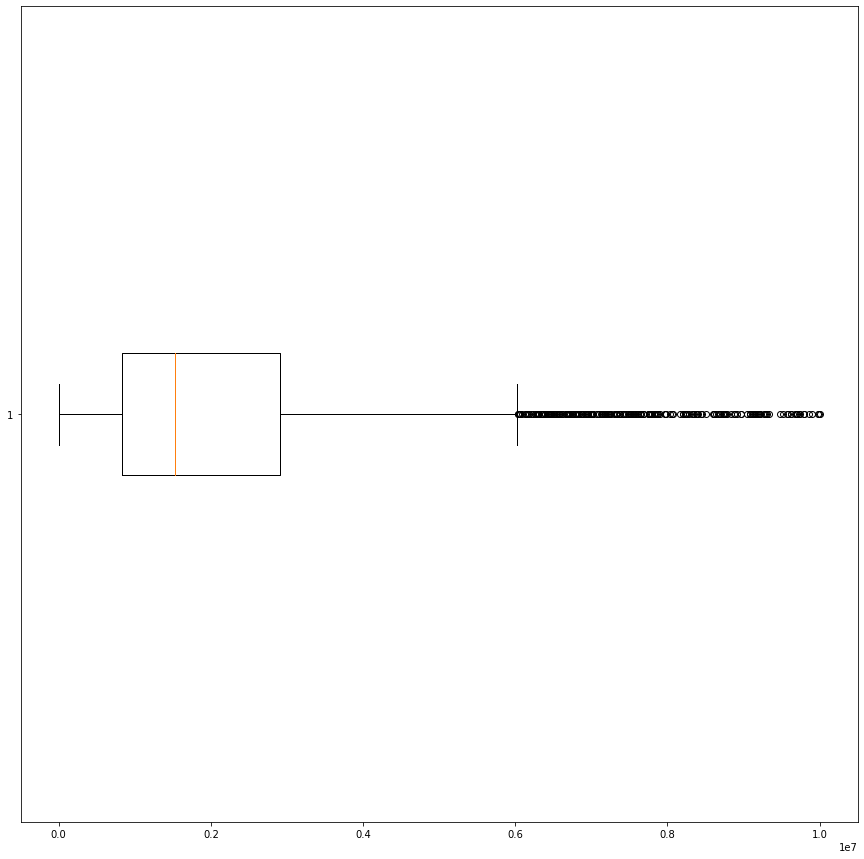

In [343]:
boxplot(bench_model_cleaned["energy_use"])

In [344]:
bench_model_cleaned.to_excel("benchmark_cleaned.xlsx", index=False)